# MSCA32019_Homework_Session_5_Pang

## Import Modules

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas_datareader as pdr
import statsmodels.tsa.stattools as ts

# Real strategy

## Part I: Presentation

                 High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2006-01-03  38.279999  36.849998  37.200001  37.450001  1013200.0  35.975586
2006-01-04  40.599998  37.700001  37.700001  39.200001  1928400.0  37.656681
2006-01-05  39.709999  38.910000  39.180000  39.709999   317900.0  38.146599
2006-01-06  39.709999  38.139999  39.709999  39.000000   349200.0  37.464558
2006-01-09  38.880001  38.500000  38.799999  38.610001   220800.0  37.089912
            aal_adj_close  ual_adj_close  luv_adj_close  alk_adj_close  \
Date                                                                     
2007-05-03      34.150387      31.374056      13.673203       6.806153   
2007-05-04      34.726765      33.263046      13.833400       6.828909   
2007-05-07      33.727707      33.169533      13.899364       6.781123   
2007-05-08      33.045662      33.459427      13.842825       6.717408   
2007-05-09      3

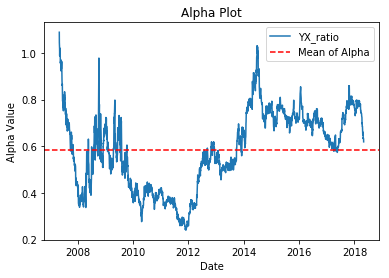

In [6]:
aal  = pdr.get_data_yahoo('AAL',  start =  datetime.datetime(2006, 1, 1), end = datetime.datetime(2018, 5, 1))
ual  = pdr.get_data_yahoo('UAL',  start =  datetime.datetime(2006, 1, 1), end = datetime.datetime(2018, 5, 1))
luv  = pdr.get_data_yahoo('LUV',  start =  datetime.datetime(2006, 1, 1), end = datetime.datetime(2018, 5, 1))
alk  = pdr.get_data_yahoo('ALK',  start =  datetime.datetime(2006, 1, 1), end = datetime.datetime(2018, 5, 1))
jblu = pdr.get_data_yahoo('JBLU', start =  datetime.datetime(2006, 1, 1), end = datetime.datetime(2018, 5, 1))
dal  = pdr.get_data_yahoo('DAL',  start =  datetime.datetime(2006, 1, 1), end = datetime.datetime(2018, 5, 1))
adj_close = pd.concat([aal['Adj Close'], ual['Adj Close'], luv['Adj Close'],
                       alk['Adj Close'], jblu['Adj Close'], dal['Adj Close']], axis = 1)
adj_close.columns = ['aal_adj_close', 'ual_adj_close', 'luv_adj_close',
                     'alk_adj_close', 'jblu_adj_close', 'dal_adj_close']
adj_close = adj_close.dropna()

def coint_multiple(df):
    cols = len(df.columns)
    r, t, p = np.ones(shape=(cols, cols)), np.ones(shape=(cols, cols)), np.ones(shape=(cols, cols))
    for i in range(cols):
        for j in range(i + 1, cols):
            x, y = adj_close.iloc[:,i].values, adj_close.iloc[:,j].values
            nas = np.logical_or(np.isnan(x), np.isnan(y))
            #r_pt = pearsonr(df.iloc[:,i][~nas], df.iloc[:,j][~nas])[0]
            #t_pt = r_pt/np.sqrt((1 - r_pt ** 2)/(len(df.iloc[:,i][~nas]) - 2))
            p_pt = ts.coint(df.iloc[:,i][~nas], df.iloc[:,j][~nas])[1]
            #r[i, j] = r[j, i] = r_pt
            #t[i, j] = t[j, i] = t_pt
            p[i, j] = p[j, i] = p_pt
    return p

print(adj_close.corr(method = 'pearson', min_periods = 1))
print(coint_multiple(adj_close))
##aal & ual has the strongest correlation: lowest p-value 0.01390708

ratio_ = adj_close['aal_adj_close']/adj_close['ual_adj_close']
ratio = pd.concat([adj_close['aal_adj_close'], adj_close['ual_adj_close'], ratio_], axis = 1)
ratio.columns = ['Y', 'X', 'YX_ratio']

plt.figure(2)
plt.plot(ratio['YX_ratio'])
plt.axhline(ratio['YX_ratio'].mean(), color='red', linestyle='--', label = 'Mean of Alpha')
plt.title("Alpha Plot")
plt.xlabel("Date")
plt.ylabel("Alpha Value")
plt.legend()

## Part II Z-score

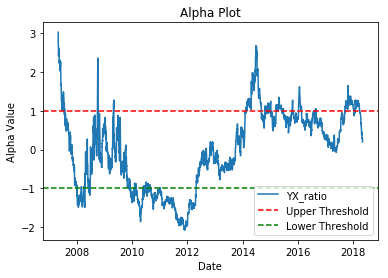

In [7]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

plt.figure(3)
plt.plot(zscore(ratio['YX_ratio']))
plt.axhline(1, color='red', linestyle='--', label = 'Upper Threshold')
plt.axhline(-1, color='green', linestyle='--', label = 'Lower Threshold')
plt.title("Alpha Plot")
plt.xlabel("Date")
plt.ylabel("Alpha Value")
plt.legend()

## Part III Building the strategy

                    Y          X  YX_ratio  YX_ratio_MA_10  YX_ratio_MA_80  \
Date                                                                         
2018-04-26  42.161118  66.620003  0.632860        0.664423        0.752692   
2018-04-27  43.186043  67.860001  0.636399        0.659467        0.751105   
2018-04-30  42.718361  67.540001  0.632490        0.654121        0.749524   
2018-05-01  43.146240  68.379997  0.630978        0.649615        0.747970   
2018-05-02  42.031761  67.919998  0.618842        0.644164        0.746282   

            YX_ratio_MStd_80  YX_ratio_zscore_80  
Date                                              
2018-04-26          0.041056           -2.149967  
2018-04-27          0.043044           -2.128936  
2018-04-30          0.045028           -2.118722  
2018-05-01          0.046932           -2.095710  
2018-05-02          0.049095           -2.079992  


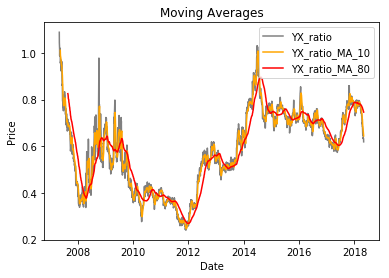

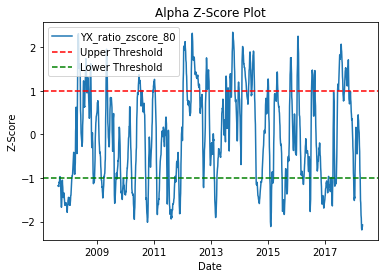

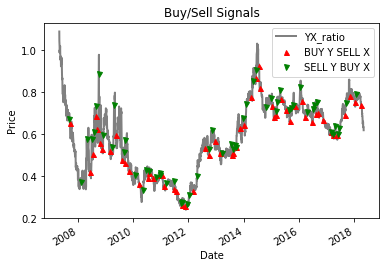

In [8]:
##Calculate moving average and standard deviation
ratio['YX_ratio_MA_10'] = ratio['YX_ratio'].rolling(10).mean()
ratio['YX_ratio_MA_80'] = ratio['YX_ratio'].rolling(80).mean()
ratio['YX_ratio_MStd_80'] = ratio['YX_ratio'].rolling(80).std()
ratio['YX_ratio_zscore_80'] = (ratio['YX_ratio_MA_10'] - ratio['YX_ratio_MA_80']) / ratio['YX_ratio_MStd_80']
print(ratio.tail())

##Plot moving average
fig = plt.figure(4)
ax = plt.subplot(111)
ax.plot(ratio['YX_ratio'], label='YX_ratio', color = 'grey')
ax.plot(ratio['YX_ratio_MA_10'], label='YX_ratio_MA_10', color = 'orange')
ax.plot(ratio['YX_ratio_MA_80'], label='YX_ratio_MA_80', color = 'red')
plt.title("Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')

##Plot rolling ratio z-score
plt.figure(5)
plt.plot(ratio['YX_ratio_zscore_80'])
plt.axhline(1, color='red', linestyle='--', label = 'Upper Threshold')
plt.axhline(-1, color='green', linestyle='--', label = 'Lower Threshold')
plt.title("Alpha Z-Score Plot")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()

#Creat buy/sell signals
signals = []
ratio_signals = ratio.copy()
if ratio['YX_ratio_zscore_80'][0] >= 1:
    signals.append('SELL Y BUY X')
elif ratio['YX_ratio_zscore_80'][0] <= -1:
    signals.append('BUY Y SELL X')
else:
    signals.append('NO ACTION')
for i in range(1, len(ratio['YX_ratio_zscore_80'])):
    if ratio['YX_ratio_zscore_80'][i] >= 1:
        if ratio['YX_ratio_zscore_80'][i - 1] < 1:
            signals.append('SELL Y BUY X')
        else:
            signals.append('NO ACTION')
    # If alpha is going below the negative threshold from normal: Buy Y and Sell X
    elif ratio['YX_ratio_zscore_80'][i] <= -1:
        if ratio['YX_ratio_zscore_80'][i - 1] > -1:
            signals.append('BUY Y SELL X')
        else:
            signals.append('NO ACTION')
    # If alpha is going back to the normal from above: Buy Y and Sell X
    # If alpha is going back to normal from below: Sell Y and Buy X
    elif abs(ratio['YX_ratio_zscore_80'][i]) < 1:
        if ratio['YX_ratio_zscore_80'][i - 1] >= 1:
            signals.append('BUY Y SELL X')
        elif ratio['YX_ratio_zscore_80'][i - 1] <= -1:
            signals.append('SELL Y BUY X')
        else:
            signals.append('NO ACTION')
    else:
        signals.append('NO ACTION')
ratio_signals['signals'] = signals

fig = plt.figure(6)
ax = fig.add_subplot(111, ylabel = 'Price')
ratio_signals[['YX_ratio']].plot(ax = ax, lw = 2., color = 'grey')
ax.plot(ratio_signals.loc[ratio_signals.signals == 'BUY Y SELL X'].index,
         ratio_signals.YX_ratio[ratio_signals.signals == 'BUY Y SELL X'], '^',
         markersize = 5, color = 'red', label = 'BUY Y SELL X')
ax.plot(ratio_signals.loc[ratio_signals.signals == 'SELL Y BUY X'].index,
         ratio_signals.YX_ratio[ratio_signals.signals == 'SELL Y BUY X'], 'v',
         markersize = 5, color = 'green', label = 'SELL Y BUY X')
plt.title("Buy/Sell Signals")
ax.legend()

## Part IV Profit

The optimal threshold is 1.5600000000000005


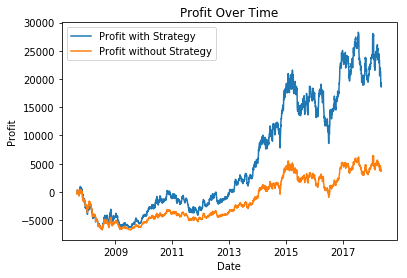

In [9]:
def portfolio(ratio):
    output = []
    for threshold in np.arange(1.00, 3.00, 0.01):
        profit = []
        profit0 = []
        diff = []
        time_index = []
        # Starting Point
        init_asset = (100 * ratio['Y'][0] + 100 * ratio['X'][0])
        num_Y, num_X = 100, 100
        if ratio['YX_ratio_zscore_80'][0] >= threshold:
            num_X += (ratio['Y'][0] * num_Y) / ratio['X'][0]
            num_Y = 0
        elif ratio['YX_ratio_zscore_80'][0] <= -threshold:
            num_Y += (ratio['X'][0] * num_X) / ratio['Y'][0]
            num_X = 0
        else:
            pass
        for i in range(1, len(ratio.index)):
            #Profit with strategy
            #If alpha is going above the positive threshold from normal: Sell Y and Buy X
            if ratio['YX_ratio_zscore_80'][i] >= threshold:
                if ratio['YX_ratio_zscore_80'][i-1]  < threshold:
                    num_X += (ratio['Y'][i] * num_Y)/ratio['X'][i]
                    num_Y = 0
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
                else:
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
            #If alpha is going below the negative threshold from normal: Buy Y and Sell X
            elif ratio['YX_ratio_zscore_80'][i] <= -threshold:
                if ratio['YX_ratio_zscore_80'][i-1] > -threshold:
                    num_Y += (ratio['X'][i] * num_X)/ratio['Y'][i]
                    num_X = 0
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
                else:
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
            #If alpha is going back to the normal from above: Buy Y and Sell X
            #If alpha is going back to normal from below: Sell Y and Buy X
            elif abs(ratio['YX_ratio_zscore_80'][i]) < threshold:
                if ratio['YX_ratio_zscore_80'][i-1] >= threshold:
                    num_Y_ = ((num_X * ratio['X'][i] + num_Y * ratio['Y'][i])/2)/ratio['Y'][i]
                    num_X_ = ((num_X * ratio['X'][i] + num_Y * ratio['Y'][i])/2)/ratio['X'][i]
                    num_Y, num_X = num_Y_, num_X_
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
                elif ratio['YX_ratio_zscore_80'][i-1] <= -threshold:
                    num_Y_ = ((num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) / 2) / ratio['Y'][i]
                    num_X_ = ((num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) / 2) / ratio['X'][i]
                    num_Y, num_X = num_Y_, num_X_
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
                else:
                    pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
            else:
                pt_profit = (num_X * ratio['X'][i] + num_Y * ratio['Y'][i]) - init_asset
            pt_profit0 = (100 * ratio['Y'][i] + 100 * ratio['X'][i]) - init_asset
            pt_diff = pt_profit - pt_profit0
            profit.append(pt_profit)
            profit0.append(pt_profit0)
            diff.append(pt_diff)
            time_index.append(ratio.index[i])
        profit_with_time = pd.concat([pd.Series(profit), pd.Series(profit0)], axis=1)
        profit_with_time.index = pd.Series(time_index)
        profit_with_time.columns = ['Profit with Strategy', 'Profit without Strategy']
        total_diff = sum(diff)
        output_ = [threshold, total_diff, profit_with_time]
        output.append(output_)
        output_df = pd.DataFrame(output)
        output_df.columns = ['threshold', 'total_diff', 'profit_with_time']
    return output_df

ratio = ratio[ratio['YX_ratio_zscore_80'].notnull()]
df = portfolio(ratio)
optimal_threshold = df.loc[(df['total_diff'] == max(df['total_diff']))].iloc[0,0]
trend_line = df.loc[(df['total_diff'] == max(df['total_diff']))].iloc[0,2]

fig = plt.figure(7)
ax = plt.subplot(111)
ax.plot(trend_line['Profit with Strategy'], label='Profit with Strategy')
ax.plot(trend_line['Profit without Strategy'], label='Profit without Strategy')
plt.title("Profit Over Time")
plt.xlabel("Date")
plt.ylabel("Profit")
plt.legend()
print("The optimal threshold is {}".format(optimal_threshold))